# 推論フェーズ

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import yaml
import os
import sys
import pandas as pd
from IPython.display import display
from typing import Any, Callable, Dict, Optional, Type, Tuple

print(torch.cuda.is_available())


True


In [6]:
# --- パス設定 ---
# プロジェクトの基点となるパスを定義
project_base_path = '/workspace/project'

# このパスがPythonの検索パスリスト (sys.path) になければ追加
if project_base_path not in sys.path:
    sys.path.append(project_base_path)
    print(f"'{project_base_path}' を sys.path に追加しました。")

# --- 自作モジュールのインポート ---
try:
    # データローダーのインポート
    from project.dataloader.data_loader_multi import MultiData
    from project.dataloader.data_loader import WalkDataModule
    
    # モデル定義のインポート
    from project.models.make_model import single, early_fusion, late_fusion, slow_fusion

    print("\n✅ 必要な全てのモジュールが正常にインポートされました。")

except ImportError as e:
    print(f"\n❌ エラー: インポートに失敗しました: {e}")
    print("\n【トラブルシューティング】")
    print("1. `project_base_path` のパスが正しいか確認してください。")
    print("2. プロジェクト内のディレクトリに `__init__.py` ファイルが存在するか確認してください。")
    # ここで処理を停止させる
    sys.exit()

'/workspace/project' を sys.path に追加しました。

✅ 必要な全てのモジュールが正常にインポートされました。


In [4]:
# ==============================================================================
# ## 2. 設定：ConfigとHParamsの準備
# ==============================================================================
print("\nステップ2: 設定ファイル (config.yaml) を読み込みます...")

# 学習済みモデルが含まれるディレクトリのルートパス
model_root = '/workspace/project/logs/resnet/slow_fusion/2025-02-03/05-15-18'

# config.yaml のパス
config_path = os.path.join(model_root, '.hydra/config.yaml')

def load_config(config_path):
    """YAMLファイルを読み込む関数"""
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        print(f"設定ファイル '{config_path}' を正常に読み込みました。")
        return config
    except FileNotFoundError:
        print(f"❌ エラー: 設定ファイル '{config_path}' が見つかりません。")
        sys.exit()

# --- HParamsクラスの定義（修正版） ---
class HParams:
    """config.yamlの階層構造を模倣するクラス"""
    def __init__(self, data_config, model_config, train_config):
        self.data = type('DataConfig', (object,), data_config)()
        self.model = type('ModelConfig', (object,), model_config)()
        self.train = type('TrainConfig', (object,), train_config)()

# --- 設定の読み込みとHParamsのインスタンス化（修正版） ---
config_data = load_config(config_path)
try:
    hparams = HParams(
        config_data['data'], 
        config_data['model'], 
        config_data['train']
    )
    print("✅ HParamsオブジェクトを正常に作成しました。")
except KeyError as e:
    print(f"❌ エラー: config.yaml に必要なキー {e} が見つかりません。")
    sys.exit()



ステップ2: 設定ファイル (config.yaml) を読み込みます...
設定ファイル '/workspace/project/logs/resnet/slow_fusion/2025-02-03/05-15-18/.hydra/config.yaml' を正常に読み込みました。
✅ HParamsオブジェクトを正常に作成しました。


In [50]:
# ==============================================================================
# ## 3. モデルの準備：インスタンス化と学習済み重みのロード
# ==============================================================================
print("\nステップ3: モデルを準備します...")

# --- 設定値の取得 ---
fusion_type = hparams.train.experiment
device_ids = 1
model_path = os.path.join(model_root, 'fold4/version_0/checkpoints/2-0.61-0.6986.ckpt')

# --- デバイスの設定 ---
if torch.cuda.is_available():
    # 指定されたGPU IDが利用可能かチェック
    if device_ids >= torch.cuda.device_count():
        print(f"\n❌ エラー: 指定されたGPU ID {device_ids} は利用できません。利用可能なGPUは {torch.cuda.device_count()}台です。")
        sys.exit()
    
    device = torch.device(f"cuda:{device_ids}")
    print(f"GPU {device_ids} を使用します。")
else:
    device = torch.device("cpu")
    print("GPUが利用できないため、CPUを使用します。")

# --- モデルのインスタンス化 ---
if fusion_type == 'single':
    model = single(hparams).to(device)
elif fusion_type == 'early_fusion':
    model = early_fusion(hparams).to(device)
elif fusion_type == 'late_fusion':
    model = late_fusion(hparams).to(device)
elif fusion_type == 'slow_fusion':
    model = slow_fusion(hparams).to(device)
else:
    raise ValueError(f"不明なフュージョンタイプ: {fusion_type}")
print(f"'{fusion_type}' モデルをインスタンス化し、デバイス '{device}' に配置しました。")

# --- 学習済み重みのロード（最終修正版） ---
try:
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if 'state_dict' in checkpoint:
        original_state_dict = checkpoint['state_dict']
        new_state_dict = {}
        # キーの先頭にある "model." プレフィックスを削除
        for k, v in original_state_dict.items():
            if k.startswith("model."):
                new_key = k[len("model."):]
            else:
                new_key = k
            new_state_dict[new_key] = v
        
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(checkpoint)
        
    model.eval() # モデルを評価モードに設定
    print("✅ 学習済み重みをモデルに正常にロードしました。")

except Exception as e:
    import traceback
    print(f"\n❌ エラー: モデルの重みロード中にエラーが発生しました: {e}")
    print(traceback.format_exc())
    sys.exit()


ステップ3: モデルを準備します...
GPU 1 を使用します。


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


'slow_fusion' モデルをインスタンス化し、デバイス 'cuda:1' に配置しました。
✅ 学習済み重みをモデルに正常にロードしました。


In [51]:
# ==============================================================================
# ## 4. 推論の実行（single / multi-stream 両対応・修正版）
# ==============================================================================
print("\nステップ4: 推論を実行します...")

# --- 4.1. 推論対象の設定 ---
AP_DATA_ROOT = '/workspace/data/out_dir_ver2_classified_front'
LAT_DATA_ROOT = '/workspace/data/out_dir_ver2_classified_side'
TARGET_FOLD = 'fold4'
INFERENCE_BATCH_SIZE = 4
# -----------------------------

results = {}

# ### ケース1: 2つの動画を入力するフュージョンモデルの場合 ###
if fusion_type in ['late_fusion', 'early_fusion', 'slow_fusion']:
    print(f"'{fusion_type}' モデル（2入力）の推論パイプラインを開始します。")
    hparams.data.ap_data_path, hparams.data.lat_data_path = AP_DATA_ROOT, LAT_DATA_ROOT
    hparams.train.current_fold = TARGET_FOLD
    hparams.data.batch_size, hparams.data.num_workers = INFERENCE_BATCH_SIZE, 0
    
    datamodule = MultiData(hparams)
    print(f"'{TARGET_FOLD}' の検証(val)データを読み込んでいます...")
    datamodule.setup(stage='test') 
    test_loader = datamodule.test_dataloader()
    print("データローダーの準備が完了しました。")

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            print(f"\n--- [バッチ {i+1}] 推論中 ---")
            batch_dict = batch[0]
            inputs_front, inputs_side = batch_dict["ap"]["video"].to(device), batch_dict["lat"]["video"].to(device)
            video_names = batch_dict["ap"]["video_name"]
            if batch_dict['ap']['video_name'] != batch_dict['lat']['video_name']:
                print('error')
            outputs = model(inputs_front, inputs_side)
            prob_for_class_1 = torch.sigmoid(outputs)
            predicted_indices = (prob_for_class_1 > 0.5).long()
            
            for idx in range(len(video_names)):
                video_name = os.path.basename(video_names[idx])
                pred_class, prob1 = predicted_indices[idx].item(), prob_for_class_1[idx].item()
                confidence = prob1 if pred_class == 1 else 1 - prob1
                results[video_name] = {'prediction': pred_class, 'confidence': f"{confidence:.4f}", 'prob_for_class_1': f"{prob1:.4f}"}
                print(f"  - {video_name}: Logit: {outputs[idx].item():.4f} -> P(class 1)={prob1:.4f} -> 予測クラス: {pred_class} (確信度: {confidence*100:.2f}%)")

# ### ケース2: 1つの動画を入力する 'single' モデルの場合（修正版） ###
elif fusion_type == 'single':
    print(f"'single' モデル（1入力）の推論パイプラインを開始します。")
    hparams.data.ap_data_path, hparams.data.lat_data_path = AP_DATA_ROOT, LAT_DATA_ROOT
    hparams.train.current_fold = TARGET_FOLD
    hparams.data.batch_size, hparams.data.num_workers = INFERENCE_BATCH_SIZE, 0
    
    datamodule = WalkDataModule(hparams)
    print(f"'{TARGET_FOLD}' の検証(val)データを読み込んでいます...")
    datamodule.setup(stage='test') 
    test_loader = datamodule.test_dataloader()
    print("データローダーの準備が完了しました。")

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            print(f"\n--- [バッチ {i+1}] 推論中 ---")
            # batch_dict = batch[0]
            input_video = batch["video"].to(device)
            video_names = batch["video_name"]
            input_video= input_video.permute(0, 2, 1, 3, 4).contiguous()
            outputs = model(input_video)
            prob_for_class_1 = torch.sigmoid(outputs)
            predicted_indices = (prob_for_class_1 > 0.5).long()
            
            for idx in range(len(video_names)):
                video_name = os.path.basename(video_names[idx])
                pred_class, prob1 = predicted_indices[idx].item(), prob_for_class_1[idx].item()
                confidence = prob1 if pred_class == 1 else 1 - prob1
                results[video_name] = {'prediction': pred_class, 'confidence': f"{confidence:.4f}", 'prob_for_class_1': f"{prob1:.4f}"}
                print(f"  - {video_name}: Logit: {outputs[idx].item():.4f} -> P(class 1)={prob1:.4f} -> 予測クラス: {pred_class} (確信度: {confidence*100:.2f}%)")
    
    

else:
    print(f"エラー: fusion_type '{fusion_type}' はこのスクリプトでサポートされていません。")

# --- 4.4. 結果の集計と表示 ---
print("\n\n==================== 全ての推論結果 ====================")
if not results:
    print("推論が実行された動画はありませんでした。")
else:
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'Video Filename'
    results_df = results_df.reset_index()
    display(results_df)


ステップ4: 推論を実行します...
'slow_fusion' モデル（2入力）の推論パイプラインを開始します。
'fold4' の検証(val)データを読み込んでいます...
データローダーの準備が完了しました。

--- [バッチ 1] 推論中 ---
  - ASD_Left_20180123_1648_1-11.mp4: Logit: -0.0151 -> P(class 1)=0.4962 -> 予測クラス: 0 (確信度: 50.38%)
  - ASD_Left_20180123_1648_10-11.mp4: Logit: -0.0761 -> P(class 1)=0.4810 -> 予測クラス: 0 (確信度: 51.90%)
  - ASD_Left_20180123_1648_11-11.mp4: Logit: -0.3759 -> P(class 1)=0.4071 -> 予測クラス: 0 (確信度: 59.29%)
  - ASD_Left_20180123_1648_2-11.mp4: Logit: -0.1205 -> P(class 1)=0.4699 -> 予測クラス: 0 (確信度: 53.01%)

--- [バッチ 2] 推論中 ---
  - ASD_Left_20180123_1648_3-11.mp4: Logit: -0.1381 -> P(class 1)=0.4655 -> 予測クラス: 0 (確信度: 53.45%)
  - ASD_Left_20180123_1648_4-11.mp4: Logit: -0.0790 -> P(class 1)=0.4803 -> 予測クラス: 0 (確信度: 51.97%)
  - ASD_Left_20180123_1648_5-11.mp4: Logit: -0.1229 -> P(class 1)=0.4693 -> 予測クラス: 0 (確信度: 53.07%)
  - ASD_Left_20180123_1648_6-11.mp4: Logit: -0.1071 -> P(class 1)=0.4733 -> 予測クラス: 0 (確信度: 52.67%)

--- [バッチ 3] 推論中 ---
  - ASD_Left_20180123_1648_7-11.m

,Video Filename,prediction,confidence,prob_for_class_1
0,ASD_Left_20180123_1648_1-11.mp4,0,0.5038,0.4962
1,ASD_Left_20180123_1648_10-11.mp4,0,0.5190,0.4810
2,ASD_Left_20180123_1648_11-11.mp4,0,0.5929,0.4071
3,ASD_Left_20180123_1648_2-11.mp4,0,0.5301,0.4699
4,ASD_Left_20180123_1648_3-11.mp4,0,0.5345,0.4655
...,...,...,...,...
1757,LCS_Right_20211012_779_2-3.mp4,0,0.6719,0.3281
1758,LCS_Right_20211012_779_3-3.mp4,0,0.7406,0.2594
1759,LCS_Right_20211012_781_1-3.mp4,0,0.7060,0.2940
1760,LCS_Right_20211012_781_2-3.mp4,0,0.7446,0.2554


In [ ]:
import json

# --- 1. 保存先のディレクトリとファイル名を定義 ---
# あなたが指定したパスをここに設定します
output_directory = '/workspace/data/analysis_logs/fails_points/slow'
output_directory = os.path.join(output_directory, TARGET_FOLD)
output_filename = 'inference_results.json'
output_filepath = os.path.join(output_directory, output_filename)

print(f"結果を次のパスに保存します: {output_filepath}")

try:
    # results辞書が空でないことを確認
    if not results:
        print("結果が空のため、JSONファイルは作成されませんでした。")
    else:
        # --- 2. 保存先ディレクトリが存在しない場合に、自動で作成 ---
        # exist_ok=True を指定すると、ディレクトリが既に存在していてもエラーになりません
        os.makedirs(output_directory, exist_ok=True)
        print(f"ディレクトリ '{output_directory}' を確認・作成しました。")

        # --- 3. ファイルを書き込む ---
        with open(output_filepath, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=4)
        
        print(f"\n✅ 推論結果が '{output_filepath}' に正常に保存されました。")

except NameError:
    print("エラー: `results` 辞書が見つかりません。先に推論処理のセルを実行してください。")
except Exception as e:
    print(f"ファイルの保存中に予期せぬエラーが発生しました: {e}")

# 描画フェーズ

ステップ1: 複数foldのJSONファイルを読み込んで統合します...
5 個のJSONファイルが見つかりました:
  - /workspace/data/analysis_logs/fails_points/slow/fold3/inference_results.json
  - /workspace/data/analysis_logs/fails_points/slow/fold2/inference_results.json
  - /workspace/data/analysis_logs/fails_points/slow/fold0/inference_results.json
  - /workspace/data/analysis_logs/fails_points/slow/fold1/inference_results.json
  - /workspace/data/analysis_logs/fails_points/slow/fold4/inference_results.json

✅ 全てのJSONデータを統合しました。

ステップ2: データフレームを処理し、分析用の列を追加します...
✅ 位置情報、正解ラベル、正誤判定の列を追加しました。

ステップ3: 詳細な位置ごとの集計を行います...
✅ 詳細分析の集計が完了しました。

ステップ4: 詳細分析の結果を可視化します...


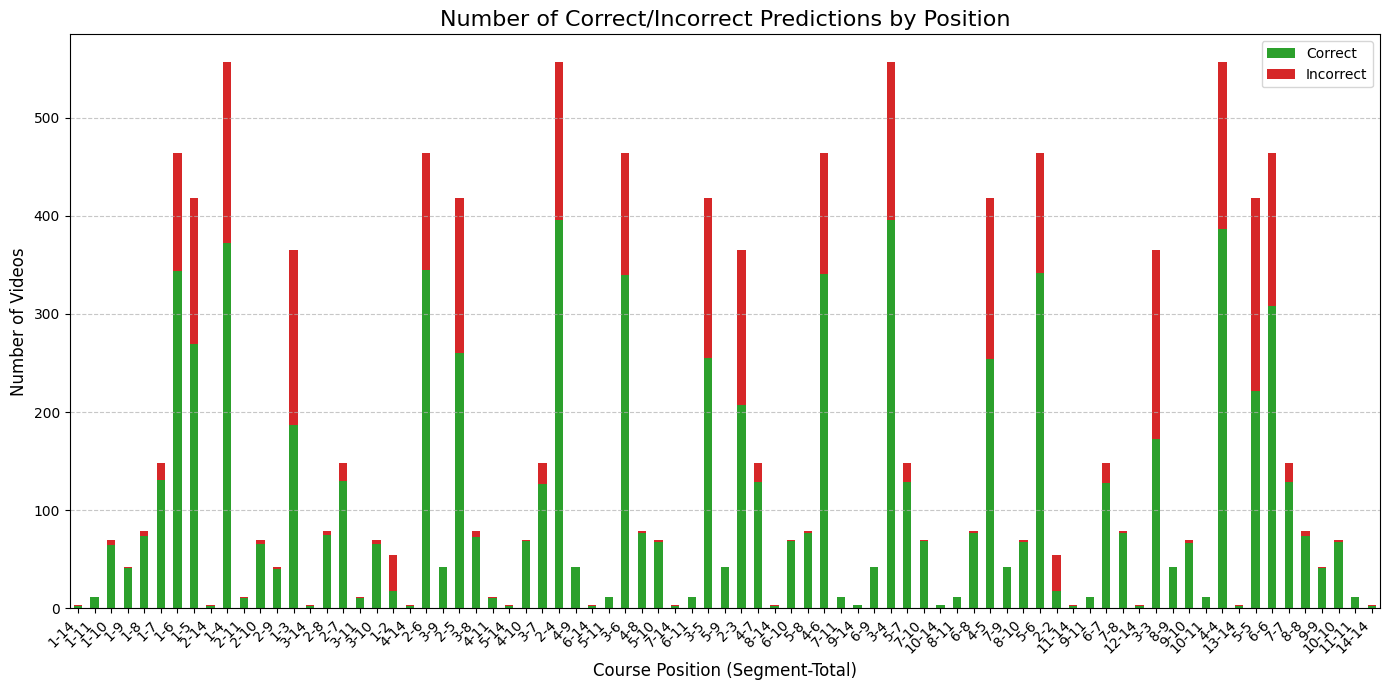

/tmp/ipykernel_408634/3816796263.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_detail = sns.barplot(x='position', y='accuracy_rate', data=position_analysis, palette='coolwarm')


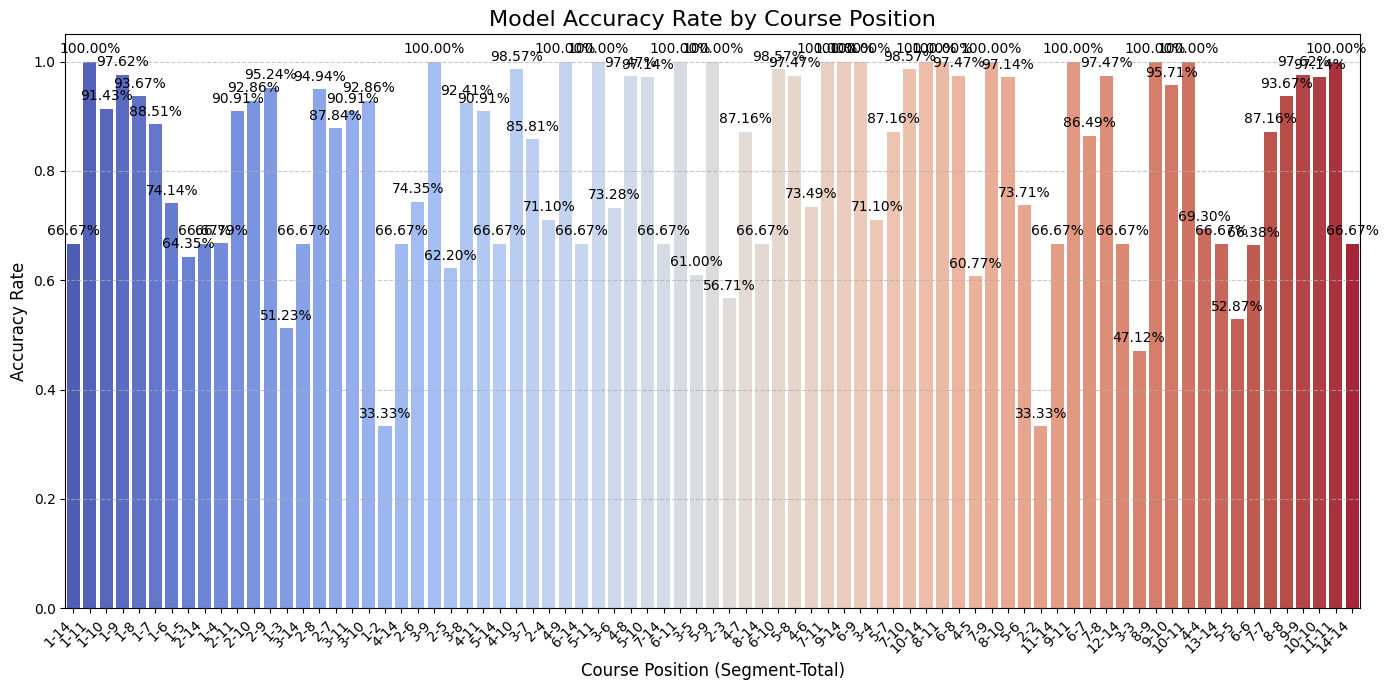


ステップ5: コースを4分割した概要分析の集計を行います...
✅ 概要分析の集計が完了しました。

ステップ6: 概要分析の結果を可視化します...

--- Accuracy Analysis by Course Quadrant ---


,quadrant,correct_count,total_count,accuracy_rate
0,1st Quadrant (0-25%),1829,2524,0.724643
1,2nd Quadrant (25-50%),1951,2591,0.752991
2,3rd Quadrant (50-75%),2170,2984,0.727212
3,4th Quadrant (75-100%),2182,3115,0.700482


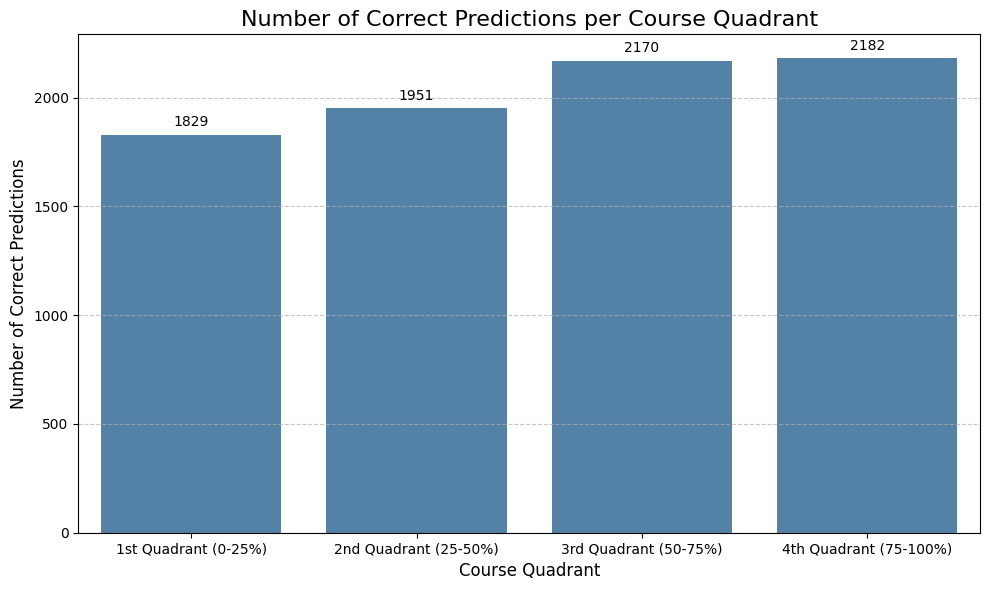

/tmp/ipykernel_408634/3816796263.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_rate_q = sns.barplot(x='quadrant', y='accuracy_rate', data=quadrant_analysis, palette='magma', order=["1st Quadrant (0-25%)", "2nd Quadrant (25-50%)", "3rd Quadrant (50-75%)", "4th Quadrant (75-100%)"])


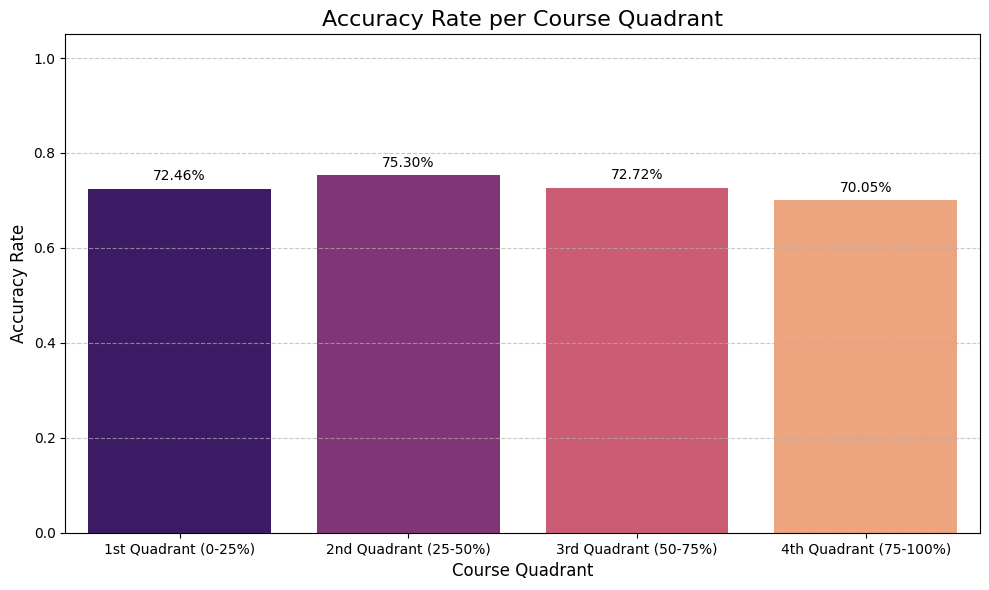

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob # ファイル検索のためのライブラリ

# ==============================================================================
# ## 1. 複数foldのJSONファイルを読み込み、単一のデータフレームに統合
# ==============================================================================
print("ステップ1: 複数foldのJSONファイルを読み込んで統合します...")

# JSONファイルが格納されている親ディレクトリを指定
JSON_ROOT_DIRECTORY = '/workspace/data/analysis_logs/fails_points/late'

# 指定したディレクトリ以下の全ての inference_results.json を探す
json_file_paths = glob.glob(os.path.join(JSON_ROOT_DIRECTORY, 'fold*', 'inference_results.json'))

if not json_file_paths:
    print(f"エラー: '{JSON_ROOT_DIRECTORY}' 内に 'foldX/inference_results.json' のパターンに一致するファイルが見つかりませんでした。")
    raise SystemExit()

print(f"{len(json_file_paths)} 個のJSONファイルが見つかりました:")
for path in json_file_paths:
    print(f"  - {path}")

# 各JSONファイルをDataFrameとして読み込み、一つのリストにまとめる
all_dfs = []
for file_path in json_file_paths:
    fold_name = os.path.basename(os.path.dirname(file_path))
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df_fold = pd.DataFrame.from_dict(data, orient='index')
    df_fold = df_fold.reset_index().rename(columns={'index': 'filename'})
    df_fold['fold'] = fold_name 
    all_dfs.append(df_fold)

# 全てのfoldのDataFrameを縦に結合
df_all = pd.concat(all_dfs, ignore_index=True)
df_all['prediction'] = df_all['prediction'].astype(int)
df_all['confidence'] = df_all['confidence'].astype(float)
print("\n✅ 全てのJSONデータを統合しました。")


# ==============================================================================
# ## 2. 統合データフレームの処理
# ==============================================================================
print("\nステップ2: データフレームを処理し、分析用の列を追加します...")

def extract_position(filename):
    try:
        base_name = os.path.splitext(filename)[0]
        position_str = base_name.split('_')[-1]
        if '-' in position_str and all(part.isdigit() for part in position_str.split('-')):
            return position_str
        return None
    except:
        return None

def get_ground_truth(filename):
    # ASD -> 0, ASD_not -> 1
    if filename.startswith('ASD'):
        return 0
    else:
        return 1

df_all['position'] = df_all['filename'].apply(extract_position)
df_all['ground_truth'] = df_all['filename'].apply(get_ground_truth)
df_all.dropna(subset=['position'], inplace=True)
df_all['is_correct'] = (df_all['prediction'] == df_all['ground_truth']).astype(int)
print("✅ 位置情報、正解ラベル、正誤判定の列を追加しました。")


# ==============================================================================
# ## 3.【詳細分析】位置ごとの集計
# ==============================================================================
print("\nステップ3: 詳細な位置ごとの集計を行います...")
position_analysis = df_all.groupby('position').agg(
    correct_count=('is_correct', 'sum'),
    total_count=('filename', 'count')
).reset_index()
position_analysis['accuracy_rate'] = position_analysis['correct_count'] / position_analysis['total_count']
position_analysis['mistake_count'] = position_analysis['total_count'] - position_analysis['correct_count']

def position_to_midpoint(position_str):
    try:
        numerator, denominator = map(int, position_str.split('-'))
        return (2 * numerator - 1) / (2 * denominator)
    except (ValueError, ZeroDivisionError):
        return float('inf')

position_analysis['sort_value'] = position_analysis['position'].apply(position_to_midpoint)
position_analysis = position_analysis.sort_values(by='sort_value').reset_index(drop=True)
print("✅ 詳細分析の集計が完了しました。")


# ==============================================================================
# ## 4.【詳細分析】結果の可視化
# ==============================================================================
print("\nステップ4: 詳細分析の結果を可視化します...")

# --- グラフA: 絶対数（積み上げ棒グラフ） ---
plot_data_detail = position_analysis.set_index('position')[['correct_count', 'mistake_count']]
plot_data_detail.plot(kind='bar', stacked=True, figsize=(14, 7), color=['#2ca02c', '#d62728'])
plt.title('Number of Correct/Incorrect Predictions by Position', fontsize=16)
plt.xlabel('Course Position (Segment-Total)', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['Correct', 'Incorrect'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_0.png'))
plt.show()


# --- グラフB: 正解率 ---
plt.figure(figsize=(14, 7))
ax_detail = sns.barplot(x='position', y='accuracy_rate', data=position_analysis, palette='coolwarm')
for p in ax_detail.patches:
    ax_detail.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Model Accuracy Rate by Course Position', fontsize=16)
plt.xlabel('Course Position (Segment-Total)', fontsize=12)
plt.ylabel('Accuracy Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_1.png'))
plt.show()


# ==============================================================================
# ## 5.【概要分析】コースを4等分した区間ごとの集計
# ==============================================================================
print("\nステップ5: コースを4分割した概要分析の集計を行います...")

def get_quadrant(midpoint_value):
    if 0 <= midpoint_value < 0.25: return "1st Quadrant (0-25%)"
    elif 0.25 <= midpoint_value < 0.5: return "2nd Quadrant (25-50%)"
    elif 0.5 <= midpoint_value < 0.75: return "3rd Quadrant (50-75%)"
    elif 0.75 <= midpoint_value <= 1.0: return "4th Quadrant (75-100%)"
    else: return "N/A"

df_all['sort_value'] = df_all['position'].apply(position_to_midpoint)
df_all['quadrant'] = df_all['sort_value'].apply(get_quadrant)

quadrant_analysis = df_all.groupby('quadrant').agg(
    correct_count=('is_correct', 'sum'),
    total_count=('filename', 'count')
).reset_index()
quadrant_analysis['accuracy_rate'] = quadrant_analysis['correct_count'] / quadrant_analysis['total_count']
print("✅ 概要分析の集計が完了しました。")


# ==============================================================================
# ## 6.【概要分析】結果の可視化
# ==============================================================================
print("\nステップ6: 概要分析の結果を可視化します...")

# --- display()で集計結果のテーブルを表示 ---
print("\n--- Accuracy Analysis by Course Quadrant ---")
display(quadrant_analysis)

# --- グラフA: 絶対数 ---
plt.figure(figsize=(10, 6))
ax_abs_q = sns.barplot(x='quadrant', y='correct_count', data=quadrant_analysis, color='steelblue', order=["1st Quadrant (0-25%)", "2nd Quadrant (25-50%)", "3rd Quadrant (50-75%)", "4th Quadrant (75-100%)"])
for p in ax_abs_q.patches:
    ax_abs_q.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Number of Correct Predictions per Course Quadrant', fontsize=16)
plt.xlabel('Course Quadrant', fontsize=12)
plt.ylabel('Number of Correct Predictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_2.png'))
plt.show()

# --- グラフB: 正解率 ---
plt.figure(figsize=(10, 6))
ax_rate_q = sns.barplot(x='quadrant', y='accuracy_rate', data=quadrant_analysis, palette='magma', order=["1st Quadrant (0-25%)", "2nd Quadrant (25-50%)", "3rd Quadrant (50-75%)", "4th Quadrant (75-100%)"])
for p in ax_rate_q.patches:
    ax_rate_q.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Accuracy Rate per Course Quadrant', fontsize=16)
plt.xlabel('Course Quadrant', fontsize=12)
plt.ylabel('Accuracy Rate', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_3.png'))
plt.show()

ステップ7: 症例別の分析（総合結果付き）を開始します...
  - 症例タイプ列を追加しました。
  - 症例タイプごとの集計が完了しました。
  - 総合結果の追加と表示順の定義が完了しました。

--- Accuracy Analysis by Case Type (with Total) ---


,case_type,correct_count,total_count,accuracy_rate
0,Total,8132,11214,0.725165
1,ASD,5923,6392,0.926627
2,DHS,1525,2371,0.643189
3,HipOA,25,834,0.029976
4,LCS,659,1617,0.407545


/tmp/ipykernel_408634/4160753937.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_abs_case = sns.barplot(x='case_type', y='correct_count', data=case_analysis_with_total, order=plot_order, palette='viridis')


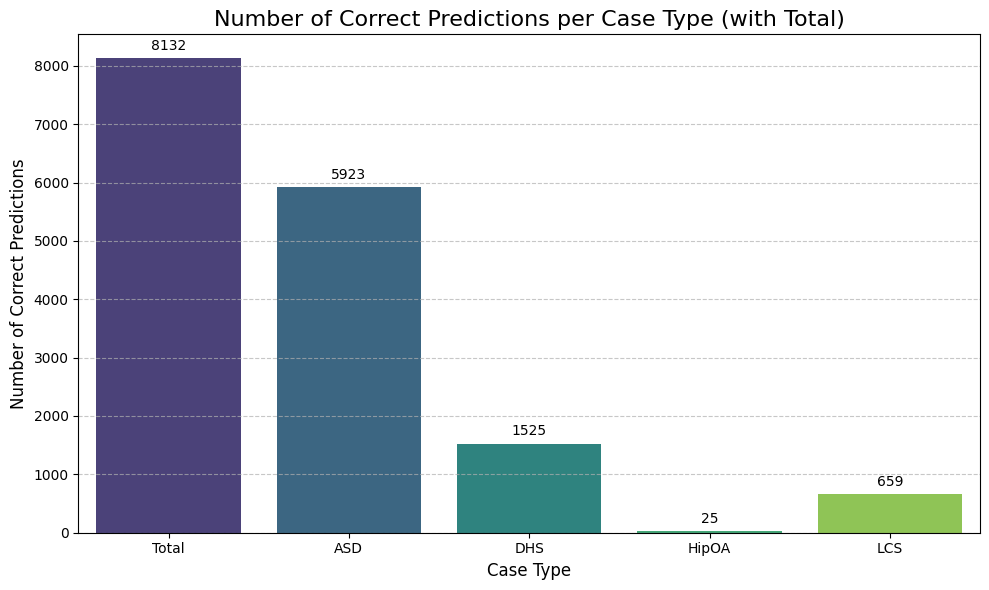

/tmp/ipykernel_408634/4160753937.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_rate_case = sns.barplot(x='case_type', y='accuracy_rate', data=case_analysis_with_total, order=plot_order, palette='plasma')


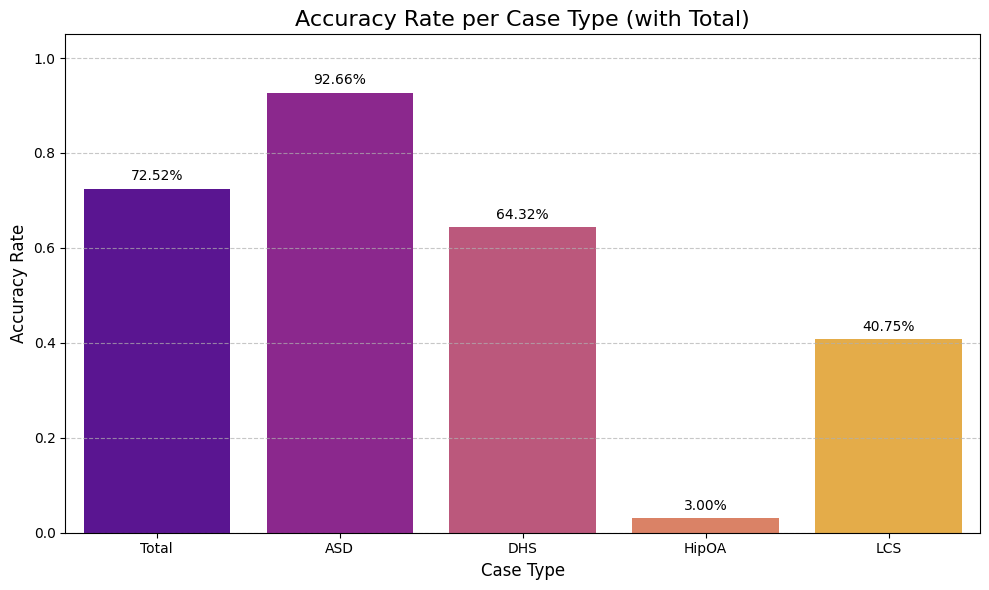

In [3]:
# ==============================================================================
# ## 7.【症例別分析＋総合】症例ごとの正解率の集計と可視化
# ==============================================================================
print("ステップ7: 症例別の分析（総合結果付き）を開始します...")

# --- 1. ファイル名から「症例タイプ」を抽出 ---
def extract_case_type(filename):
    try:
        return filename.split('_')[0]
    except:
        return None

# 'case_type' 列を新しく作成
df_all['case_type'] = df_all['filename'].apply(extract_case_type)
print("  - 症例タイプ列を追加しました。")


# --- 2. 症例タイプごとに正解率と絶対数を集計 ---
# 'case_type' 列でグループ化し、正解数と全体の数を計算
case_analysis = df_all.groupby('case_type').agg(
    correct_count=('is_correct', 'sum'),
    total_count=('filename', 'count')
).reset_index()

# 正解率を計算
case_analysis['accuracy_rate'] = case_analysis['correct_count'] / case_analysis['total_count']
print("  - 症例タイプごとの集計が完了しました。")


# --- 3. 「総合(Total)」の行を計算して追加 ---
# 全体の合計を計算
total_correct = case_analysis['correct_count'].sum()
total_total = case_analysis['total_count'].sum()
total_accuracy = total_correct / total_total if total_total > 0 else 0

# 'Total'の行を新しいDataFrameとして作成
total_df = pd.DataFrame([{
    'case_type': 'Total',
    'correct_count': total_correct,
    'total_count': total_total,
    'accuracy_rate': total_accuracy
}])

# 元のDataFrameと結合して、'Total'行を含む新しいDataFrameを作成
case_analysis_with_total = pd.concat([total_df, case_analysis], ignore_index=True)

# グラフの表示順を定義 ('Total'を先頭に、残りはアルファベット順)
plot_order = ['Total'] + sorted(case_analysis['case_type'].unique())
print("  - 総合結果の追加と表示順の定義が完了しました。")


# --- 4. 可視化 (2パターン、総合結果付き) ---

# display()で集計結果のテーブルを表示
print("\n--- Accuracy Analysis by Case Type (with Total) ---")
display(case_analysis_with_total)


# ### パターンA: 正解の「絶対数」を可視化 ###
plt.figure(figsize=(10, 6))
ax_abs_case = sns.barplot(x='case_type', y='correct_count', data=case_analysis_with_total, order=plot_order, palette='viridis')
for p in ax_abs_case.patches:
    ax_abs_case.annotate(f"{p.get_height():.0f}", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Number of Correct Predictions per Case Type (with Total)', fontsize=16)
plt.xlabel('Case Type', fontsize=12)
plt.ylabel('Number of Correct Predictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_4.png'))
plt.show()


# ### パターンB: 「正解率」を可視化 ###
plt.figure(figsize=(10, 6))
ax_rate_case = sns.barplot(x='case_type', y='accuracy_rate', data=case_analysis_with_total, order=plot_order, palette='plasma')
for p in ax_rate_case.patches:
    ax_rate_case.annotate(f"{p.get_height():.2%}", 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Accuracy Rate per Case Type (with Total)', fontsize=16)
plt.xlabel('Case Type', fontsize=12)
plt.ylabel('Accuracy Rate', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(JSON_ROOT_DIRECTORY, 'output_5.png'))
plt.show()

In [16]:
# =============================================================================
# セル 1: ライブラリのインポートと設定
# =============================================================================
import os
import json
import pandas as pd
import re

# pandasの表示オプションを設定して、表が途中で省略されないようにする
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

# =============================================================================
# セル 3: データの読み込みと基本分析
# =============================================================================
print("--- データの読み込みと基本分析を開始します ---")
inp_dir = JSON_ROOT_DIRECTORY
all_results = []

for i in range(5):
    fold_name = f'fold{i}'
    json_path = os.path.join(inp_dir, fold_name, 'inference_results.json')

    if os.path.exists(json_path):
        print(f"{json_path} を読み込んでいます...")
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for filename, results in data.items():
            parts = filename.split('_')
            ground_truth = parts[0]
            direction = parts[1]
            
            prediction_val = results['prediction']
            prediction_label = 'ASD' if prediction_val == 0 else 'ASD以外の疾患'

            is_correct = (ground_truth == 'ASD' and prediction_label == 'ASD') or \
                         (ground_truth != 'ASD' and prediction_label == 'ASD以外の疾患')

            all_results.append({
                'fold': i,
                'filename': filename,
                'direction': direction,
                'ground_truth': ground_truth,
                'prediction_label': prediction_label,
                'confidence': float(results['confidence']),
                'is_correct': is_correct
            })

results_df = pd.DataFrame(all_results)
print("データの読み込みと基本分析が完了しました。\n")


# =============================================================================
# セル 4: Zone分類と最終集計（Right/Left全体比較を追加）
# =============================================================================

def get_zone(row):
    """ファイル名と方向からZoneを判定する関数"""
    filename = row['filename']
    direction = row['direction']

    name_without_ext = os.path.splitext(filename)[0]
    match = re.search(r'(\d+)[-_](\d+)$', name_without_ext)
    if not match: return 'zone_unknown'

    a = int(match.group(1))
    b = int(match.group(2))

    if b == 0 or (a - 1) < 0: return 'zone_unknown'

    avg = ((a / b) + ((a - 1) / b)) / 2
    
    if direction == 'Left':
        if (0 <= avg <= 0.25) or (0.75 <= avg <= 1): return 'zone-1'
        elif 0.25 < avg < 0.75: return 'zone-2'
    elif direction == 'Right':
        if (0 <= avg <= 0.125) or (0.875 <= avg <= 1): return 'zone-0'
        elif (0.125 < avg <= 0.3125) or (0.6875 <= avg < 0.875): return 'zone-1'
        elif 0.3125 < avg < 0.6875: return 'zone-2'
            
    return 'zone_unknown'

if not results_df.empty:
    print("--- Zoneの分類と集計を開始します ---")
    
    # 信頼スコアと正解値(1 or 0)の差を計算
    results_df['confidence_diff'] = np.where(
        results_df['is_correct'],
        1.0 - results_df['confidence'],
        results_df['confidence']
    )
    
    # Zone列を追加
    results_df['zone'] = results_df.apply(get_zone, axis=1)
    
    print("--- 分析結果 ---")

    # 1.【詳細サマリー】方向(Right/Left)とZoneごとの集計
    summary_detailed = results_df.groupby(['direction', 'zone']).agg(
        total_count=('is_correct', 'count'),
        correct_count=('is_correct', 'sum'),
        avg_confidence_diff=('confidence_diff', 'mean')
    ).reset_index()
    summary_detailed['accuracy'] = (summary_detailed['correct_count'] / summary_detailed['total_count'])
    
    # 表示用にフォーマット
    summary_detailed_display = summary_detailed.copy()
    summary_detailed_display['accuracy'] = summary_detailed_display['accuracy'].apply(lambda x: f"{x:.2%}")
    summary_detailed_display['avg_confidence_diff'] = summary_detailed_display['avg_confidence_diff'].apply(lambda x: f"{x:.4f}")
    
    print("\n[1. 方向(Right/Left)とZoneごとの詳細サマリー]")
    display(summary_detailed_display)

    # #################################################
    # ### ここが追加点です ###
    # #################################################
    # 2.【全体サマリー】方向(Right/Left)ごとの集計
    summary_direction = results_df.groupby('direction').agg(
        total_count=('is_correct', 'count'),
        correct_count=('is_correct', 'sum'),
        avg_confidence_diff=('confidence_diff', 'mean')
    ).reset_index()
    summary_direction['accuracy'] = (summary_direction['correct_count'] / summary_direction['total_count'])

    # 表示用にフォーマット
    summary_direction_display = summary_direction.copy()
    summary_direction_display['accuracy'] = summary_direction_display['accuracy'].apply(lambda x: f"{x:.2%}")
    summary_direction_display['avg_confidence_diff'] = summary_direction_display['avg_confidence_diff'].apply(lambda x: f"{x:.4f}")

    print("\n[2. 方向(Right/Left)ごとの全体サマリー]")
    display(summary_direction_display)
    
    # 3. 全データの詳細を表示
    print("\n[3. 全データ詳細]")
    display(results_df)
    
    # 6. CSVファイルとして保存
    save_csv_dir = '/workspace/data/analysis_logs/fails_points'
    fusion_method=os.path.basename(JSON_ROOT_DIRECTORY)
    output_csv_name = 'prediction_analysis_with_zone.csv'
    save_csv_path = os.path.join(save_csv_dir, fusion_method, output_csv_name)
    results_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')
    print(f"\n全データ詳細を '{save_csv_path}' に保存しました。")

else:
    print("データが見つからなかったため、分析を実行できませんでした。")

--- データの読み込みと基本分析を開始します ---
/workspace/data/analysis_logs/fails_points/slow/fold0/inference_results.json を読み込んでいます...
/workspace/data/analysis_logs/fails_points/slow/fold1/inference_results.json を読み込んでいます...
/workspace/data/analysis_logs/fails_points/slow/fold2/inference_results.json を読み込んでいます...
/workspace/data/analysis_logs/fails_points/slow/fold3/inference_results.json を読み込んでいます...
/workspace/data/analysis_logs/fails_points/slow/fold4/inference_results.json を読み込んでいます...
データの読み込みと基本分析が完了しました。

--- Zoneの分類と集計を開始します ---
--- 分析結果 ---

[1. 方向(Right/Left)とZoneごとの詳細サマリー]


,direction,zone,total_count,correct_count,avg_confidence_diff,accuracy
0,Left,zone-1,3556,2727,0.3431,76.69%
1,Left,zone-2,2962,2226,0.3626,75.15%
2,Right,zone-0,1490,1066,0.3731,71.54%
3,Right,zone-1,1428,829,0.4754,58.05%
4,Right,zone-2,1778,1284,0.3816,72.22%



[2. 方向(Right/Left)ごとの全体サマリー]


,direction,total_count,correct_count,avg_confidence_diff,accuracy
0,Left,6518,4953,0.3519,75.99%
1,Right,4696,3179,0.4074,67.70%



[3. 全データ詳細]


,fold,filename,direction,ground_truth,prediction_label,confidence,is_correct,confidence_diff,zone
0,0,ASD_Left_20180521_1_1507_1-9.mp4,Left,ASD,ASD,0.8669,True,0.1331,zone-1
1,0,ASD_Left_20180521_1_1507_2-9.mp4,Left,ASD,ASD,0.8473,True,0.1527,zone-1
2,0,ASD_Left_20180521_1_1507_3-9.mp4,Left,ASD,ASD,0.8613,True,0.1387,zone-2
3,0,ASD_Left_20180521_1_1507_4-9.mp4,Left,ASD,ASD,0.8427,True,0.1573,zone-2
4,0,ASD_Left_20180521_1_1507_5-9.mp4,Left,ASD,ASD,0.8389,True,0.1611,zone-2
...,...,...,...,...,...,...,...,...,...
11209,4,LCS_Right_20211012_779_2-3.mp4,Right,LCS,ASD,0.6719,False,0.6719,zone-2
11210,4,LCS_Right_20211012_779_3-3.mp4,Right,LCS,ASD,0.7406,False,0.7406,zone-1
11211,4,LCS_Right_20211012_781_1-3.mp4,Right,LCS,ASD,0.7060,False,0.7060,zone-1
11212,4,LCS_Right_20211012_781_2-3.mp4,Right,LCS,ASD,0.7446,False,0.7446,zone-2



全データ詳細を '/workspace/data/analysis_logs/fails_points/slow/prediction_analysis_with_zone.csv' に保存しました。
